In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd

In [2]:
tckrs = ["ADBE", "AMAT", "AMZN", "BRK-B", "DAL", "GOOG", "MCD"]

In [3]:
start = "2019-12-18"
end = "2021-11-01"
lookahead = 5

In [4]:
dates = pd.date_range(start, end)

In [5]:
base = "/home/greg_b/voltron/experiments/trading/saved-outputs/"

In [6]:
full_predictions = []
has_dates = []
for date in dates:
    cap = str(date)[:10]
    try:
        predictions = torch.stack([torch.load(base + tckr + "/volt_ewma50_"+cap+".pt") for tckr in tckrs])
        full_predictions.append(predictions)
        has_dates.append(cap)
    except:
        print(cap)

2019-12-21
2019-12-22
2019-12-25
2019-12-28
2019-12-29
2020-01-01
2020-01-04
2020-01-05
2020-01-11
2020-01-12
2020-01-18
2020-01-19
2020-01-20
2020-01-25
2020-01-26
2020-02-01
2020-02-02
2020-02-08
2020-02-09
2020-02-15
2020-02-16
2020-02-17
2020-02-22
2020-02-23
2020-02-29
2020-03-01
2020-03-07
2020-03-08
2020-03-14
2020-03-15
2020-03-21
2020-03-22
2020-03-28
2020-03-29
2020-04-04
2020-04-05
2020-04-10
2020-04-11
2020-04-12
2020-04-18
2020-04-19
2020-04-25
2020-04-26
2020-05-02
2020-05-03
2020-05-09
2020-05-10
2020-05-16
2020-05-17
2020-05-23
2020-05-24
2020-05-25
2020-05-30
2020-05-31
2020-06-06
2020-06-07
2020-06-13
2020-06-14
2020-06-20
2020-06-21
2020-06-27
2020-06-28
2020-07-03
2020-07-04
2020-07-05
2020-07-11
2020-07-12
2020-07-18
2020-07-19
2020-07-25
2020-07-26
2020-08-01
2020-08-02
2020-08-08
2020-08-09
2020-08-15
2020-08-16
2020-08-22
2020-08-23
2020-08-29
2020-08-30
2020-09-05
2020-09-06
2020-09-07
2020-09-12
2020-09-13
2020-09-19
2020-09-20
2020-09-26
2020-09-27
2020-10-03

In [7]:
daily_predictions = torch.stack(full_predictions)

In [8]:
daily_predictions.shape

torch.Size([472, 7, 1000, 20])

In [9]:
from pandas.tseries.holiday import USFederalHolidayCalendar


In [10]:
date

Timestamp('2021-11-01 00:00:00', freq='D')

In [11]:
bday_us = pd.offsets.CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [12]:
end_plus_20 = str(pd.date_range(start=end, periods=21, freq=bday_us)[-1])[:10]

In [13]:
observations = torch.tensor(
    [yf.download(tckr, start=start, end=end_plus_20).Close.values for tckr in tckrs]
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_62715/2183553156.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/torch/csrc/utils/tensor_new.cpp:201.)
  observations = torch.tensor(


In [14]:
daily_predictions.shape

torch.Size([472, 7, 1000, 20])

In [15]:
num_obs = daily_predictions.shape[0]

In [16]:
tenday_lookahead = daily_predictions[..., lookahead].permute(1, 2, 0)

In [17]:
exp_means = tenday_lookahead.exp().mean(1)
exp_stds = tenday_lookahead.exp().std(1)

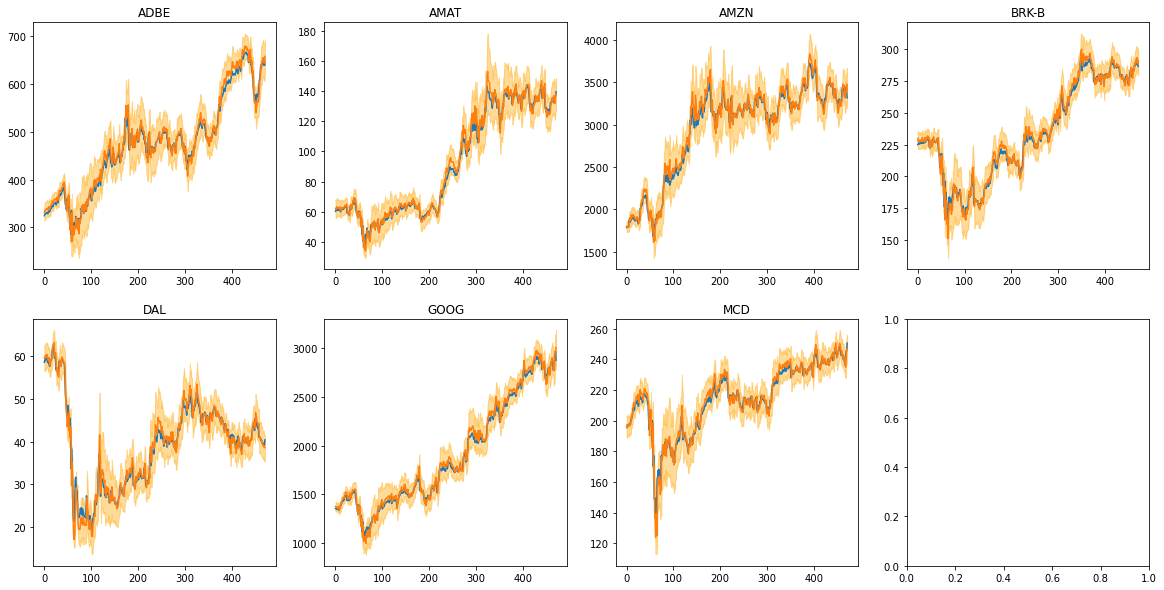

In [18]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))
ax = ax.reshape(-1)

for i in range(7):
    # ax[i].plot(torch.arange(-lookahead, -lookahead+num_obs+22), observations[i])
    ax[i].plot(observations[i, :-20])
    ax[i].plot(exp_means[i])
    ax[i].fill_between(
        torch.arange(num_obs), 
        (exp_means - 2 * exp_stds)[i],
        (exp_means + 2 * exp_stds)[i],
        alpha = 0.4, 
        color = "orange"
    )
    ax[i].set_title(tckrs[i])

In [19]:
returns_for_cov = (observations[..., lookahead:] - observations[..., :-lookahead]) \
    / observations[..., :-lookahead]

In [20]:
returns_for_cov.shape

torch.Size([7, 487])

In [21]:
lookahead_price = tenday_lookahead.exp()

In [22]:
lookahead_price.shape

torch.Size([7, 1000, 472])

In [23]:
returns_from_preds = (lookahead_price[..., lookahead:] - lookahead_price[..., :-lookahead]) \
    / lookahead_price[..., :-lookahead]

In [24]:
lookahead_price[..., lookahead:].shape

torch.Size([7, 1000, 467])

In [25]:
returns_from_obs = (lookahead_price[..., lookahead:] - observations[..., :-(lookahead+20)].unsqueeze(-2)) \
    / observations[..., :-(lookahead+20)].unsqueeze(-2)

In [26]:
returns_from_preds.shape

torch.Size([7, 1000, 467])

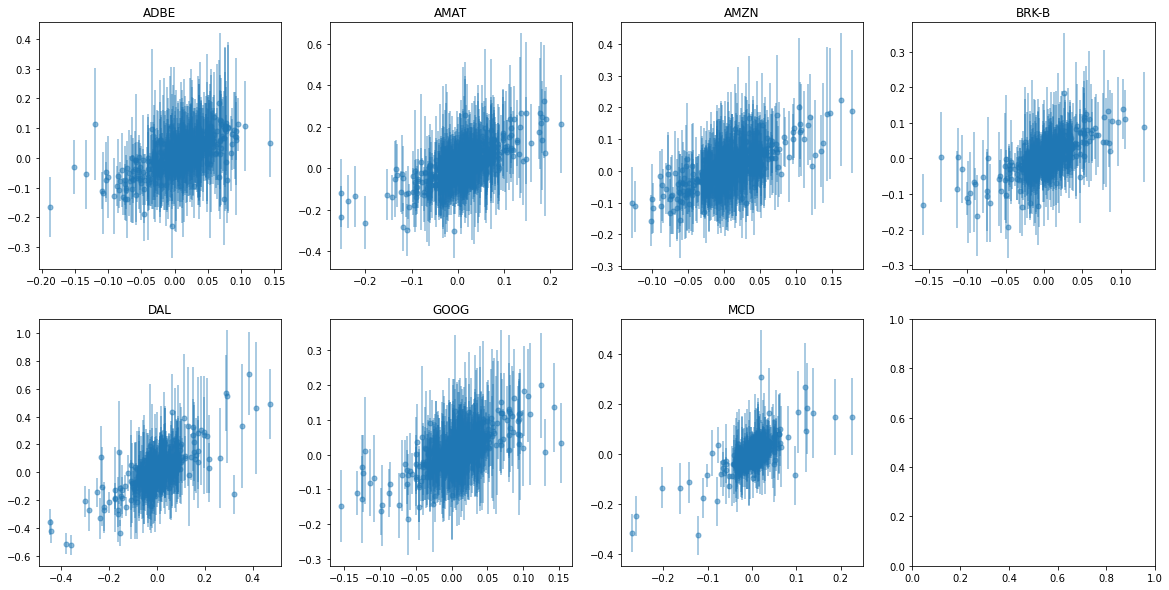

In [27]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))
ax = ax.reshape(-1)

for i in range(7):
    # ax[i].plot(torch.arange(-lookahead, -lookahead+num_obs+22), observations[i])
    ax[i].errorbar(returns_for_cov[i, :-20], returns_from_preds[i].mean(0), 
                   yerr=returns_from_preds[i].std(0) * 2., ls = "none",
                  marker = ".", markersize = 10, alpha = 0.5)
    ax[i].set_title(tckrs[i])

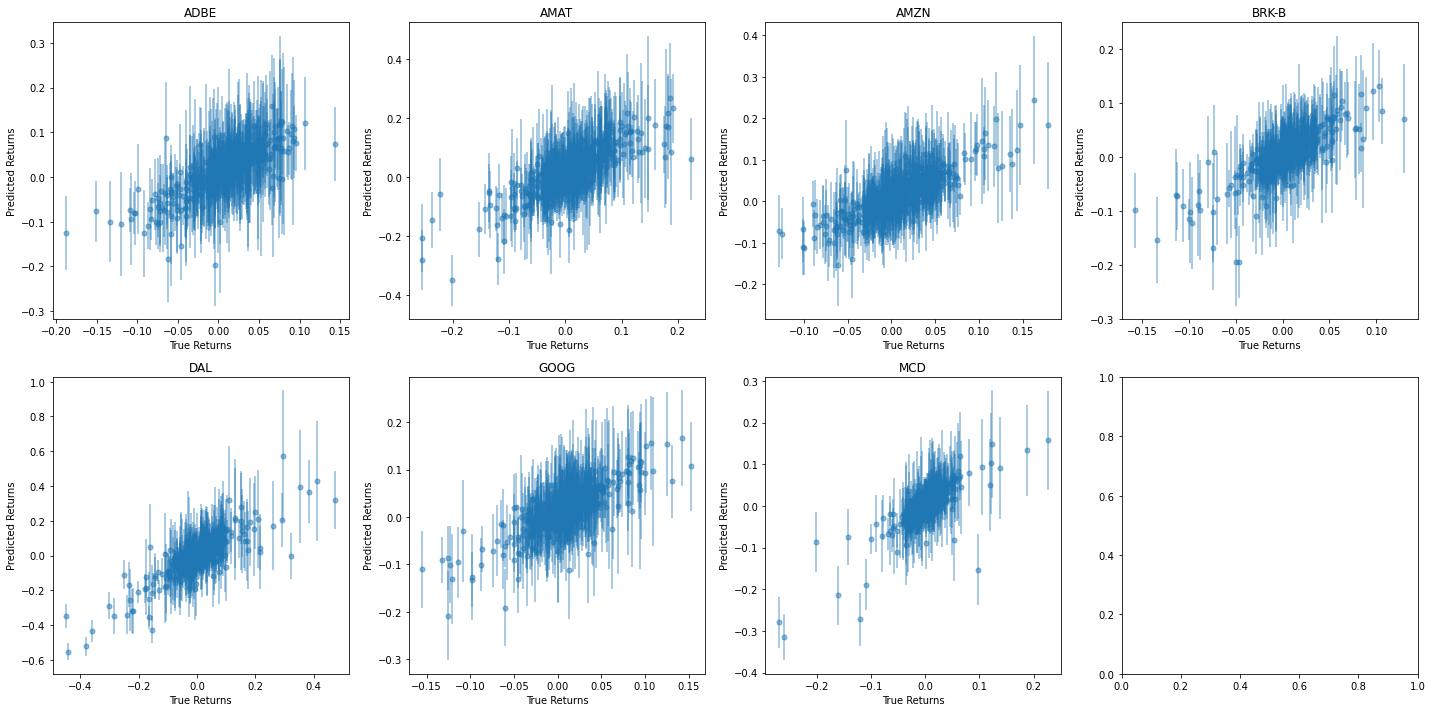

In [28]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))
ax = ax.reshape(-1)

for i in range(7):
    # ax[i].plot(torch.arange(-lookahead, -lookahead+num_obs+22), observations[i])
    ax[i].errorbar(returns_for_cov[i, :-20], returns_from_obs[i].mean(0), 
                   yerr=returns_from_obs[i].std(0) * 2., ls = "none",
                  marker = ".", markersize = 10, alpha = 0.5)
    ax[i].set_title(tckrs[i])
    ax[i].set_xlabel("True Returns")
    ax[i].set_ylabel("Predicted Returns")
plt.tight_layout()

In [29]:
excess_returns = returns_from_obs - lookahead / 252 * 0.03

In [30]:
mean_excess_returns = excess_returns.mean(1)

In [31]:
cov_excess_returns = torch.stack([torch.cov(excess_returns[..., i]) for i in range(excess_returns.shape[-1])])

In [39]:
torch.cov(returns_for_cov[..., :20])

tensor([[ 9.4396e-05,  8.3951e-05, -8.9049e-05,  1.5895e-05,  1.5878e-04,
          1.1348e-04,  5.1337e-05],
        [ 8.3951e-05,  2.3471e-04, -4.2566e-05,  5.3674e-05,  2.0328e-04,
          1.0539e-04,  3.8734e-05],
        [-8.9049e-05, -4.2566e-05,  5.2625e-04,  8.5269e-06, -3.0660e-04,
         -1.5089e-04, -5.0121e-05],
        [ 1.5895e-05,  5.3674e-05,  8.5269e-06,  3.8392e-05,  9.4610e-05,
          1.8853e-05,  9.9285e-06],
        [ 1.5878e-04,  2.0328e-04, -3.0660e-04,  9.4610e-05,  9.6952e-04,
          1.2703e-04,  7.8414e-05],
        [ 1.1348e-04,  1.0539e-04, -1.5089e-04,  1.8853e-05,  1.2703e-04,
          3.5054e-04,  1.8897e-04],
        [ 5.1337e-05,  3.8734e-05, -5.0121e-05,  9.9285e-06,  7.8414e-05,
          1.8897e-04,  1.3370e-04]], dtype=torch.float64)

In [40]:
opt_excess_returns = returns_for_cov - lookahead / 252 * 0.03
cov_opt_excess_returns = torch.stack(
    [torch.cov(opt_excess_returns[..., :i]) for i in range(opt_excess_returns.shape[-1])]
)

/tmp/ipykernel_62715/1267487358.py:3: UserWarning: cov(): degrees of freedom is <= 0 (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/Correlation.cpp:99.)
  [torch.cov(opt_excess_returns[..., :i]) for i in range(opt_excess_returns.shape[-1])]


In [61]:
cov_opt_excess_returns[0:2] = cov_opt_excess_returns[2]

In [62]:
def compute_strategy(excess_returns, cov_est=None):
    if cov_est is None:
        batched_covs = torch.stack([torch.cov(excess_returns[..., i]) for i in range(excess_returns.shape[-1])])
    else:
        batched_covs = cov_est
    expected_returns = excess_returns.mean(1)
    
    weights = torch.solve(expected_returns.t().unsqueeze(-1), batched_covs)[0]
    norm_constant = expected_returns.t().unsqueeze(-2).matmul(weights).sum(-1)
    return weights.squeeze(-1) / norm_constant

In [63]:
weights = compute_strategy(mean_excess_returns, cov_excess_returns) / (252 / 5)

In [64]:
obs_returns = (weights * returns_for_cov[..., :-20].t()).sum(1).cumsum(0)

In [65]:
hodl_returns = returns_for_cov[..., :-20].t().mean(1).cumsum(0)

In [73]:
opt_weights = compute_strategy(opt_excess_returns, cov_opt_excess_returns) / (252 / 5)

In [74]:
opt_excess_returns

tensor([[ 0.0204,  0.0090,  0.0016,  ..., -0.0138, -0.0019, -0.0061],
        [ 0.0148,  0.0076, -0.0148,  ..., -0.0979,  0.0073, -0.0030],
        [ 0.0469,  0.0427,  0.0332,  ..., -0.0524, -0.0319, -0.0189],
        ...,
        [ 0.0161, -0.0016, -0.0059,  ..., -0.0938, -0.0875, -0.0904],
        [ 0.0052, -0.0037, -0.0106,  ..., -0.0530, -0.0262, -0.0321],
        [ 0.0067,  0.0050, -0.0018,  ..., -0.0143, -0.0071, -0.0356]],
       dtype=torch.float64)

In [75]:
cov_opt_excess_returns[1]

tensor([[6.4749e-05, 4.0746e-05, 2.4165e-05, 1.2918e-05, 1.0096e-04, 5.0140e-05,
         9.5412e-06],
        [4.0746e-05, 2.5641e-05, 1.5207e-05, 8.1289e-06, 6.3533e-05, 3.1553e-05,
         6.0042e-06],
        [2.4165e-05, 1.5207e-05, 9.0186e-06, 4.8210e-06, 3.7679e-05, 1.8713e-05,
         3.5609e-06],
        [1.2918e-05, 8.1289e-06, 4.8210e-06, 2.5771e-06, 2.0142e-05, 1.0003e-05,
         1.9035e-06],
        [1.0096e-04, 6.3533e-05, 3.7679e-05, 2.0142e-05, 1.5742e-04, 7.8181e-05,
         1.4877e-05],
        [5.0140e-05, 3.1553e-05, 1.8713e-05, 1.0003e-05, 7.8181e-05, 3.8828e-05,
         7.3885e-06],
        [9.5412e-06, 6.0042e-06, 3.5609e-06, 1.9035e-06, 1.4877e-05, 7.3885e-06,
         1.4060e-06]], dtype=torch.float64)

In [76]:
opt_weights.shape

torch.Size([487, 7])

In [77]:
opt_returns = (opt_weights[:-20] * returns_for_cov[..., :-20].t()).sum(1).cumsum(0)

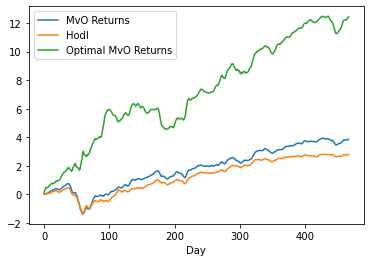

In [78]:
plt.plot(obs_returns, label = "MvO Returns")
plt.plot(hodl_returns, label = "Hodl")
plt.plot(opt_returns, label = "Optimal MvO Returns")
plt.xlabel("Day")
plt.legend()